<a href="https://colab.research.google.com/github/SS1031/kaggle-shopee/blob/main/notebooks/010_ocr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install ipython-autotime

In [2]:
%load_ext autotime

time: 87.5 µs (started: 2021-04-05 13:15:10 +00:00)


In [3]:
!nvidia-smi

Mon Apr  5 13:15:11 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
!pip install keras_ocr

time: 2.32 s (started: 2021-04-05 13:15:11 +00:00)


In [5]:
!mkdir -p "/kaggle/input/"
!cp "/content/drive/MyDrive/kaggle-shopee/shopee-product-matching.zip" "/kaggle/input/"
!unzip -qq "/kaggle/input/shopee-product-matching.zip" -d "/kaggle/input/shopee-product-matching"
!rm -rf "/kaggle/input/shopee-product-matching.zip"

BASE = "/kaggle/input/shopee-product-matching"

replace /kaggle/input/shopee-product-matching/sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: time: 2min 26s (started: 2021-04-05 13:15:14 +00:00)


In [17]:
import matplotlib.pyplot as plt
import keras_ocr

import numpy as np
import pandas as pd

from time import time
from tqdm import tqdm
import re
import itertools
import multiprocessing
import gc
import cv2

time: 2.66 ms (started: 2021-04-05 13:23:38 +00:00)


In [18]:

def displayDF(train, random=False, COLS=6, ROWS=4, path=BASE + "/train_images/"):
    for k in range(ROWS):
        plt.figure(figsize=(20, 5))
        for j in range(COLS):
            if random: row = np.random.randint(0,len(train))
            else: row = COLS*k + j
            name = train.iloc[row, 1]
            title = train.iloc[row, 3]
            title_with_return = ""
            for i,ch in enumerate(title):
                title_with_return += ch
                if (i!=0)&(i%20==0): title_with_return += '\n'
            img = cv2.imread(path + name)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt.subplot(1, COLS, j+1)
            plt.title(title_with_return)
            plt.axis('off')
            plt.imshow(img)
        plt.show()
        

time: 10.2 ms (started: 2021-04-05 13:23:39 +00:00)


In [19]:
df = pd.read_csv(f"{BASE}/train.csv")

grp = 0

grp_length = int(len(df) / 10)
START_INDEX = grp_length * grp
END_INDEX = grp_length * (grp + 1)


time: 97.7 ms (started: 2021-04-05 13:23:40 +00:00)


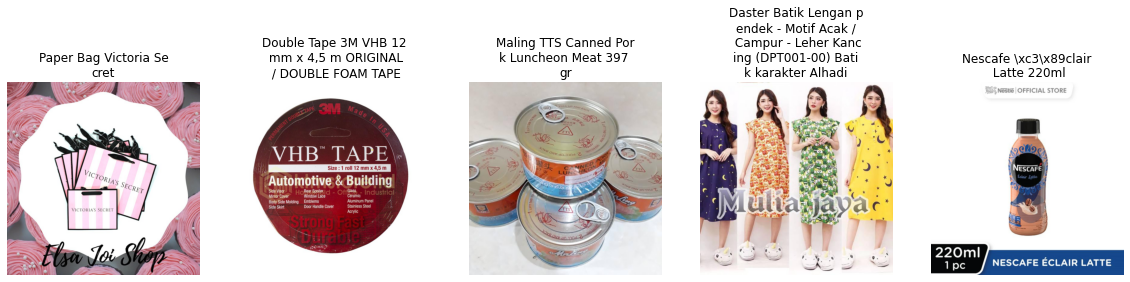

time: 644 ms (started: 2021-04-05 13:23:40 +00:00)


In [20]:
displayDF(df.iloc[START_INDEX:END_INDEX], COLS=5, ROWS=1)

In [21]:
paths = [f"{BASE}/train_images/{p}" for p in df.image.values]

time: 15.8 ms (started: 2021-04-05 13:23:41 +00:00)


In [22]:
pipeline = keras_ocr.pipeline.Pipeline()

Looking for /root/.keras-ocr/craft_mlt_25k.h5
Looking for /root/.keras-ocr/crnn_kurapan.h5
time: 2.61 s (started: 2021-04-05 13:23:42 +00:00)


In [23]:
BATCH_PREDICT = 10

list_texts = list()
for i in tqdm(range(START_INDEX, END_INDEX, BATCH_PREDICT)):
    try:
        if i + BATCH_PREDICT < END_INDEX:
            images = [keras_ocr.tools.resize_image(keras_ocr.tools.read(p), 512, 512)[0] for p in paths[i:i + BATCH_PREDICT]]
        else:
            images = [keras_ocr.tools.resize_image(keras_ocr.tools.read(p), 512, 512)[0] for p in paths[i:END_INDEX]]

        prediction_groups = pipeline.recognize(images)

        for x in range(len(prediction_groups)):
            texts = []
            for y in range(len(prediction_groups[x])):
                texts.append(prediction_groups[x][y][0])

            list_texts.append(texts)
        gc.collect()
    except:
        if i + BATCH_PREDICT < END_INDEX:
            for j in range(BATCH_PREDICT):
                list_texts.append([])
        else:
            for j in range(END_INDEX - i):
                list_texts.append([])

  0%|          | 0/343 [00:00<?, ?it/s]

  0%|          | 1/343 [00:04<26:38,  4.67s/it]

100%|██████████| 343/343 [17:39<00:00,  3.09s/it]

time: 17min 39s (started: 2021-04-05 13:23:44 +00:00)


In [24]:
ocr_df = pd.DataFrame({"image": df.iloc[START_INDEX: END_INDEX, 1], "ocr_texts": list_texts})

time: 6.03 ms (started: 2021-04-05 13:41:24 +00:00)


In [25]:
import os

out_dir = "/content/drive/MyDrive/kaggle-shopee/ocr_train_image"
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

ocr_df.to_csv(f"{out_dir}/ocr{str(grp).zfill(2)}-{START_INDEX}-{END_INDEX}.csv", index=False)

time: 37.9 ms (started: 2021-04-05 13:41:24 +00:00)
